In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
import itertools

import statsmodels as sm
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.stattools import acf 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import pacf 
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima_process import arma_generate_sample

from statsmodels.tsa.arima.model import ARIMA

import pmdarima as pm
from pmdarima import model_selection

import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.tsa.seasonal import seasonal_decompose


from sklearn.preprocessing import OneHotEncoder

In [2]:
data = pd.read_csv('./data/zillow_data.csv')

In [3]:
df_weekly = pd.read_csv('./data/zillow_weekly_data.csv')

In [4]:
def melt_data_weekly(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [5]:
weekly_melt =  melt_data_weekly(df_weekly)
weekly_melt.set_index('time', inplace = True)
weekly_melt.index = pd.to_datetime(weekly_melt.index)
weekly_melt.rename(columns = {'value':'Price'}, inplace = True)

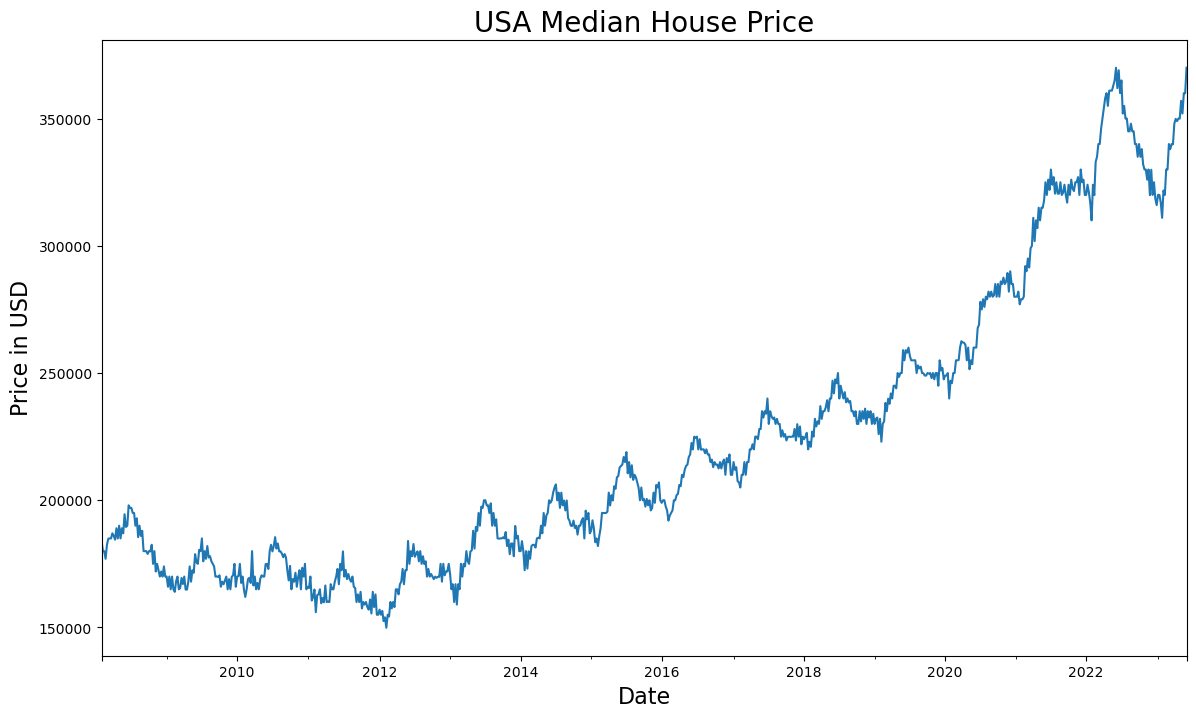

In [6]:
fig, ax = plt.subplots(figsize = (14,8))

weekly_melt[weekly_melt['RegionName'] == 'United States']['Price'].plot(ax = ax)

ax.set_title('USA Median House Price', fontsize = 20)

ax.set_xlabel('Date', fontsize = 16);
ax.set_ylabel('Price in USD', fontsize = 16)

plt.show();

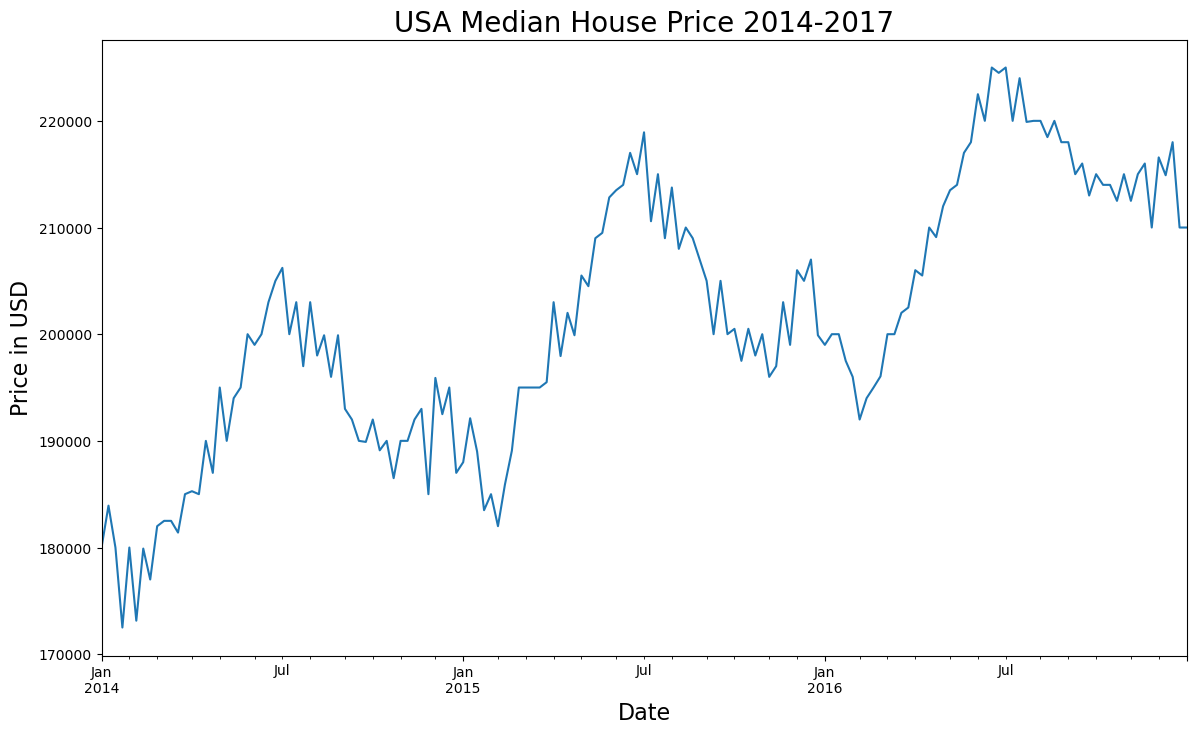

In [7]:
fig, ax = plt.subplots(figsize = (14,8))

weekly_melt[weekly_melt['RegionName'] == 'United States']['2014':'2016']['Price'].plot(ax = ax)

ax.set_title('USA Median House Price 2014-2017', fontsize = 20)

ax.set_xlabel('Date', fontsize = 16);
ax.set_ylabel('Price in USD', fontsize = 16)

plt.show();

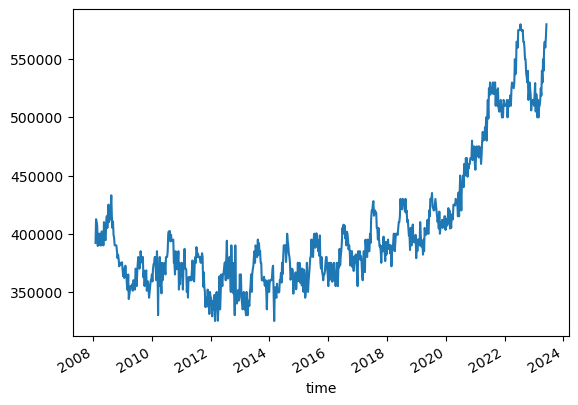

In [8]:
weekly_melt[weekly_melt['RegionName'] == 'New York, NY']['Price'].plot();

In [9]:
weekly_melt['StateName'].unique()

array([nan, 'NY', 'CA', 'IL', 'TX', 'VA', 'PA', 'FL', 'GA', 'MA', 'AZ',
       'MI', 'MN', 'CO', 'MD', 'MO', 'NC', 'OR', 'OH', 'NV', 'IN', 'TN',
       'RI', 'WI', 'OK', 'KY', 'UT', 'CT', 'AL', 'HI', 'NE', 'SC', 'NM',
       'ID', 'AR', 'MS', 'ME', 'LA', 'DE', 'WA', 'NJ'], dtype=object)

In [10]:
weekly_melt

,RegionID,SizeRank,RegionName,RegionType,StateName,Price
time,,,,,,
2008-02-02,102001,0,United States,country,NaN,184169.0
2008-02-02,394913,1,"New York, NY",msa,NY,392000.0
2008-02-02,753899,2,"Los Angeles, CA",msa,CA,475000.0
2008-02-02,394463,3,"Chicago, IL",msa,IL,239500.0
2008-02-02,394514,4,"Dallas, TX",msa,TX,137550.0
...,...,...,...,...,...,...
2023-06-03,394917,282,"Niles, MI",msa,MI,339500.0
2023-06-03,394685,289,"Homosassa Springs, FL",msa,FL,266150.0
2023-06-03,394442,321,"Carbondale, IL",msa,IL,132950.0


In [11]:
def date_features(df):
    """
    Data features for time series analysis
    """
    df = df.copy()
    df['year'] = df.index.year
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear

    return df

In [12]:
nyc = weekly_melt[weekly_melt['RegionName'] == 'New York, NY']

In [13]:
nyc

,RegionID,SizeRank,RegionName,RegionType,StateName,Price
time,,,,,,
2008-02-02,394913,1,"New York, NY",msa,NY,392000.0
2008-02-09,394913,1,"New York, NY",msa,NY,412500.0
2008-02-16,394913,1,"New York, NY",msa,NY,410000.0
2008-02-23,394913,1,"New York, NY",msa,NY,406850.0
2008-03-01,394913,1,"New York, NY",msa,NY,389500.0
...,...,...,...,...,...,...
2023-05-06,394913,1,"New York, NY",msa,NY,561750.0
2023-05-13,394913,1,"New York, NY",msa,NY,565000.0
2023-05-20,394913,1,"New York, NY",msa,NY,560000.0


In [14]:
nyc = date_features(nyc)

In [15]:
nyc.columns

Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'Price', 'year', 'quarter', 'month', 'dayofyear'],
      dtype='object')

In [16]:
features = ['year', 'quarter', 'month', 'dayofyear']

In [17]:
nyc_train = nyc.loc[nyc.index < '2019-01-01']
nyc_test = nyc.loc[(nyc.index >= '2019-01-01')]# & (nyc.index < '2020-01-01')]

In [18]:
X_train_nyc = nyc_train[features]
y_train_nyc = nyc_train['Price']

X_test_nyc = nyc_test[features]
y_test_nyc = nyc_test['Price']

In [19]:
reg_2 = xgb.XGBRegressor(n_estimators=1000, learning_rate = .05)
reg_2.fit(X_train_nyc, y_train_nyc,
        eval_set=[(X_train_nyc, y_train_nyc), (X_test_nyc, y_test_nyc)],
        early_stopping_rounds=100,
       verbose=True)

[0]	validation_0-rmse:356875.07558	validation_1-rmse:460682.41357
[1]	validation_0-rmse:339129.05404	validation_1-rmse:443035.55882
[2]	validation_0-rmse:322272.20666	validation_1-rmse:426279.71886
[3]	validation_0-rmse:306260.34558	validation_1-rmse:410370.55921
[4]	validation_0-rmse:291051.50451	validation_1-rmse:395265.97162
[5]	validation_0-rmse:276605.78341	validation_1-rmse:380925.87843
[6]	validation_0-rmse:262885.30929	validation_1-rmse:367312.23333
[7]	validation_0-rmse:249854.07945	validation_1-rmse:354388.81677
[8]	validation_0-rmse:237477.95525	validation_1-rmse:342121.27143
[9]	validation_0-rmse:225724.44765	validation_1-rmse:330476.85263
[10]	validation_0-rmse:214560.20796	validation_1-rmse:318426.28758
[11]	validation_0-rmse:203956.17937	validation_1-rmse:306985.58366
[12]	validation_0-rmse:193884.66841	validation_1-rmse:296124.63645
[13]	validation_0-rmse:184319.36703	validation_1-rmse:285814.78228
[14]	validation_0-rmse:175234.03615	validation_1-rmse:276028.85411
[15]	

[125]	validation_0-rmse:5675.77504	validation_1-rmse:93272.06726
[126]	validation_0-rmse:5656.50894	validation_1-rmse:93237.43568
[127]	validation_0-rmse:5611.25424	validation_1-rmse:93205.98848
[128]	validation_0-rmse:5579.79561	validation_1-rmse:93176.31169
[129]	validation_0-rmse:5562.21654	validation_1-rmse:93149.40952
[130]	validation_0-rmse:5547.32222	validation_1-rmse:93108.74165
[131]	validation_0-rmse:5511.46757	validation_1-rmse:93085.06805
[132]	validation_0-rmse:5493.79575	validation_1-rmse:93071.27020
[133]	validation_0-rmse:5459.77192	validation_1-rmse:93048.24753
[134]	validation_0-rmse:5440.72907	validation_1-rmse:93026.48520
[135]	validation_0-rmse:5414.78489	validation_1-rmse:93002.89529
[136]	validation_0-rmse:5377.35435	validation_1-rmse:92983.75124
[137]	validation_0-rmse:5344.93897	validation_1-rmse:92967.44957
[138]	validation_0-rmse:5325.20324	validation_1-rmse:92946.19357
[139]	validation_0-rmse:5300.99785	validation_1-rmse:92924.98480


/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[140]	validation_0-rmse:5279.96859	validation_1-rmse:92902.07846
[141]	validation_0-rmse:5243.40036	validation_1-rmse:92873.56607
[142]	validation_0-rmse:5227.11185	validation_1-rmse:92855.22420
[143]	validation_0-rmse:5207.91460	validation_1-rmse:92834.90157
[144]	validation_0-rmse:5173.56306	validation_1-rmse:92809.58406
[145]	validation_0-rmse:5158.68327	validation_1-rmse:92797.99986
[146]	validation_0-rmse:5145.11019	validation_1-rmse:92786.62609
[147]	validation_0-rmse:5130.84972	validation_1-rmse:92777.00546
[148]	validation_0-rmse:5106.35883	validation_1-rmse:92769.87708
[149]	validation_0-rmse:5091.84469	validation_1-rmse:92747.31840
[150]	validation_0-rmse:5077.72825	validation_1-rmse:92728.72341
[151]	validation_0-rmse:5043.80551	validation_1-rmse:92707.31553
[152]	validation_0-rmse:5013.06298	validation_1-rmse:92687.84341
[153]	validation_0-rmse:4985.46938	validation_1-rmse:92671.88995
[154]	validation_0-rmse:4969.29166	validation_1-rmse:92664.31672
[155]	validation_0-rmse:4

[267]	validation_0-rmse:3785.00478	validation_1-rmse:92301.82464
[268]	validation_0-rmse:3779.40172	validation_1-rmse:92302.93488
[269]	validation_0-rmse:3774.11936	validation_1-rmse:92299.95376
[270]	validation_0-rmse:3772.61033	validation_1-rmse:92300.06318
[271]	validation_0-rmse:3765.18552	validation_1-rmse:92302.20113
[272]	validation_0-rmse:3755.83651	validation_1-rmse:92305.73472
[273]	validation_0-rmse:3745.84752	validation_1-rmse:92303.96771
[274]	validation_0-rmse:3740.84232	validation_1-rmse:92302.30577
[275]	validation_0-rmse:3739.41421	validation_1-rmse:92302.15081
[276]	validation_0-rmse:3725.82364	validation_1-rmse:92307.48206
[277]	validation_0-rmse:3715.13917	validation_1-rmse:92307.98666
[278]	validation_0-rmse:3711.48485	validation_1-rmse:92309.33464
[279]	validation_0-rmse:3704.60786	validation_1-rmse:92308.68462
[280]	validation_0-rmse:3699.28742	validation_1-rmse:92309.81065
[281]	validation_0-rmse:3694.76631	validation_1-rmse:92307.01836
[282]	validation_0-rmse:3

[394]	validation_0-rmse:2965.64797	validation_1-rmse:92276.44381
[395]	validation_0-rmse:2964.16642	validation_1-rmse:92275.72524
[396]	validation_0-rmse:2957.50171	validation_1-rmse:92274.64923
[397]	validation_0-rmse:2951.17965	validation_1-rmse:92273.04107
[398]	validation_0-rmse:2945.17541	validation_1-rmse:92272.03351
[399]	validation_0-rmse:2936.49289	validation_1-rmse:92269.24084
[400]	validation_0-rmse:2935.85472	validation_1-rmse:92268.99696
[401]	validation_0-rmse:2935.17917	validation_1-rmse:92270.26588
[402]	validation_0-rmse:2927.13348	validation_1-rmse:92267.72786
[403]	validation_0-rmse:2919.83148	validation_1-rmse:92268.17827
[404]	validation_0-rmse:2912.47537	validation_1-rmse:92266.05808
[405]	validation_0-rmse:2902.18079	validation_1-rmse:92266.44445
[406]	validation_0-rmse:2893.82290	validation_1-rmse:92267.49717
[407]	validation_0-rmse:2884.62456	validation_1-rmse:92265.25510
[408]	validation_0-rmse:2877.32249	validation_1-rmse:92265.96984
[409]	validation_0-rmse:2

[521]	validation_0-rmse:2313.65170	validation_1-rmse:92218.21271
[522]	validation_0-rmse:2312.39722	validation_1-rmse:92217.44943
[523]	validation_0-rmse:2306.83535	validation_1-rmse:92218.41916
[524]	validation_0-rmse:2306.43801	validation_1-rmse:92218.52791
[525]	validation_0-rmse:2303.28811	validation_1-rmse:92218.86389
[526]	validation_0-rmse:2298.76059	validation_1-rmse:92217.68511
[527]	validation_0-rmse:2295.82090	validation_1-rmse:92218.01434
[528]	validation_0-rmse:2294.38983	validation_1-rmse:92218.26634
[529]	validation_0-rmse:2290.50849	validation_1-rmse:92217.92351
[530]	validation_0-rmse:2286.86282	validation_1-rmse:92217.56964
[531]	validation_0-rmse:2278.31289	validation_1-rmse:92219.23892
[532]	validation_0-rmse:2277.55747	validation_1-rmse:92219.04364
[533]	validation_0-rmse:2271.16876	validation_1-rmse:92218.36837
[534]	validation_0-rmse:2266.33457	validation_1-rmse:92221.11461
[535]	validation_0-rmse:2262.29033	validation_1-rmse:92219.98145
[536]	validation_0-rmse:2

[648]	validation_0-rmse:1848.05165	validation_1-rmse:92185.65371
[649]	validation_0-rmse:1842.41102	validation_1-rmse:92185.99700
[650]	validation_0-rmse:1836.99269	validation_1-rmse:92186.86445
[651]	validation_0-rmse:1834.93341	validation_1-rmse:92186.08340
[652]	validation_0-rmse:1833.07327	validation_1-rmse:92185.86547
[653]	validation_0-rmse:1827.51035	validation_1-rmse:92185.12290
[654]	validation_0-rmse:1825.05390	validation_1-rmse:92185.42399
[655]	validation_0-rmse:1820.77770	validation_1-rmse:92185.69163
[656]	validation_0-rmse:1819.31179	validation_1-rmse:92184.59080
[657]	validation_0-rmse:1811.20806	validation_1-rmse:92184.39390
[658]	validation_0-rmse:1804.99570	validation_1-rmse:92185.63339
[659]	validation_0-rmse:1799.90376	validation_1-rmse:92184.64803
[660]	validation_0-rmse:1798.22046	validation_1-rmse:92184.26671
[661]	validation_0-rmse:1796.62911	validation_1-rmse:92184.19648
[662]	validation_0-rmse:1794.69892	validation_1-rmse:92184.61682
[663]	validation_0-rmse:1

[775]	validation_0-rmse:1475.40343	validation_1-rmse:92169.87636
[776]	validation_0-rmse:1473.70997	validation_1-rmse:92168.03213
[777]	validation_0-rmse:1470.20915	validation_1-rmse:92166.50179
[778]	validation_0-rmse:1465.23727	validation_1-rmse:92166.57491
[779]	validation_0-rmse:1463.62897	validation_1-rmse:92166.64060
[780]	validation_0-rmse:1461.22513	validation_1-rmse:92167.18622
[781]	validation_0-rmse:1457.37071	validation_1-rmse:92166.70637
[782]	validation_0-rmse:1454.08653	validation_1-rmse:92165.23624
[783]	validation_0-rmse:1452.21848	validation_1-rmse:92164.72678
[784]	validation_0-rmse:1447.50449	validation_1-rmse:92164.60008
[785]	validation_0-rmse:1444.84017	validation_1-rmse:92164.02501
[786]	validation_0-rmse:1441.04166	validation_1-rmse:92165.44438
[787]	validation_0-rmse:1435.11144	validation_1-rmse:92164.51199
[788]	validation_0-rmse:1433.48266	validation_1-rmse:92164.37154
[789]	validation_0-rmse:1430.21603	validation_1-rmse:92163.62448
[790]	validation_0-rmse:1

[902]	validation_0-rmse:1227.40976	validation_1-rmse:92155.17427
[903]	validation_0-rmse:1223.45567	validation_1-rmse:92155.16341
[904]	validation_0-rmse:1217.70228	validation_1-rmse:92155.19152
[905]	validation_0-rmse:1212.78581	validation_1-rmse:92155.05721
[906]	validation_0-rmse:1207.18008	validation_1-rmse:92155.14302
[907]	validation_0-rmse:1206.64586	validation_1-rmse:92155.10528
[908]	validation_0-rmse:1205.16849	validation_1-rmse:92154.97196
[909]	validation_0-rmse:1203.09736	validation_1-rmse:92154.17594
[910]	validation_0-rmse:1197.79254	validation_1-rmse:92154.65295
[911]	validation_0-rmse:1193.15038	validation_1-rmse:92154.59924
[912]	validation_0-rmse:1188.96268	validation_1-rmse:92154.97998
[913]	validation_0-rmse:1188.43497	validation_1-rmse:92154.92422
[914]	validation_0-rmse:1185.81133	validation_1-rmse:92153.95707
[915]	validation_0-rmse:1182.81280	validation_1-rmse:92154.04829
[916]	validation_0-rmse:1177.81544	validation_1-rmse:92153.98224
[917]	validation_0-rmse:1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [20]:
nyc_train['Predicted'] = reg_2.predict(X_train_nyc)
nyc_test['Predicted'] = reg_2.predict(X_test_nyc)

/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_8961/2814559478.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc_train['Predicted'] = reg_2.predict(X_train_nyc)
/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_8961/2814559478.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc_test['Predicted'] = reg_2.predict(X_test_nyc)


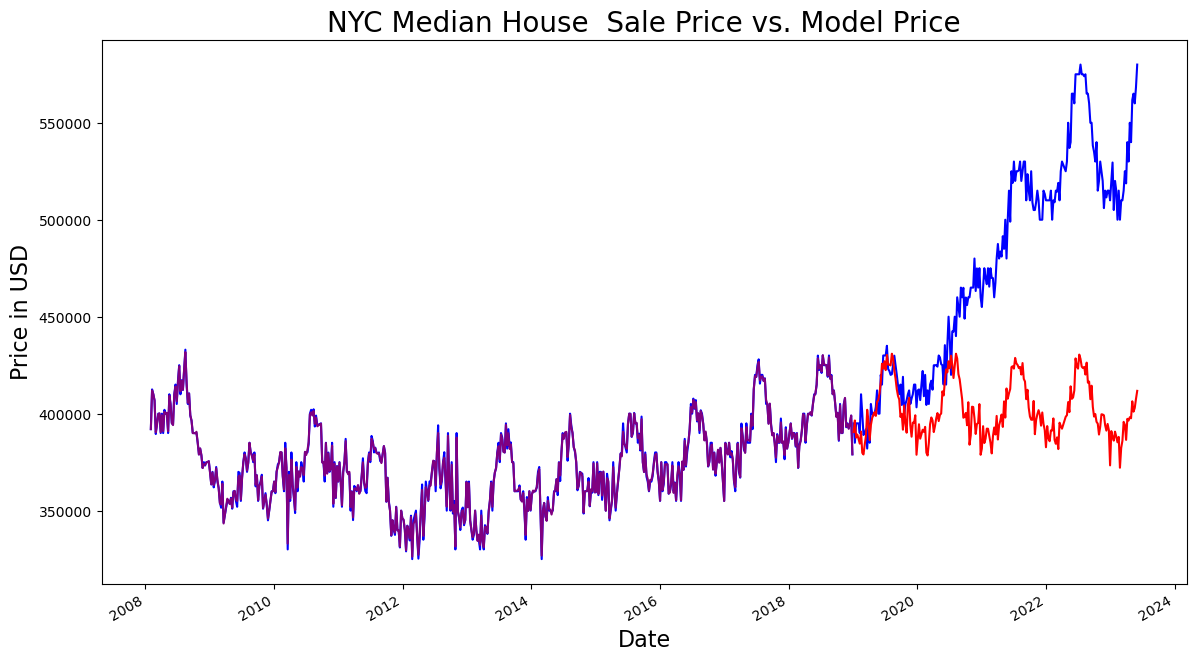

In [22]:
fig, ax = plt.subplots(figsize = (14,8))

nyc_train['Price'].plot(color = 'blue')
nyc_train['Predicted'].plot(color = 'purple')

nyc_test['Price'].plot(color = 'blue')
nyc_test['Predicted'].plot(color = 'red')


ax.set_title('NYC Median House  Sale Price vs. Model Price', fontsize = 20)

ax.set_xlabel('Date', fontsize = 16);
ax.set_ylabel('Price in USD', fontsize = 16)

plt.show();

In [23]:
nyc_train = nyc.loc[nyc.index < '2020-01-01']
nyc_test = nyc.loc[(nyc.index >= '2020-01-01')]

In [24]:
nash = weekly_melt[weekly_melt['RegionName'] == 'Nashville, TN']

In [25]:
nash = date_features(nash)

In [26]:
nash_train = nash.loc[nash.index < '2021-01-01']
nash_test = nash.loc[(nash.index >= '2021-01-01')]

In [27]:
X_train_nash = nash_train[features]
y_train_nash = nash_train['Price']

X_test_nash = nash_test[features]
y_test_nash = nash_test['Price']

In [28]:
reg_nash = xgb.XGBRegressor(n_estimators=1000, learning_rate = .01)
reg_nash.fit(X_train_nash, y_train_nash,
        eval_set=[(X_train_nash, y_train_nash), (X_test_nash, y_test_nash)],
        early_stopping_rounds=100,
       verbose=True)

[0]	validation_0-rmse:204622.22156	validation_1-rmse:391763.79510
[1]	validation_0-rmse:202602.15335	validation_1-rmse:388937.17844
[2]	validation_0-rmse:200602.24757	validation_1-rmse:386138.72048
[3]	validation_0-rmse:198622.31454	validation_1-rmse:383368.19861
[4]	validation_0-rmse:196662.14855	validation_1-rmse:380625.33544
[5]	validation_0-rmse:194721.55600	validation_1-rmse:377909.84316
[6]	validation_0-rmse:192800.33992	validation_1-rmse:375221.41481
[7]	validation_0-rmse:190898.31613	validation_1-rmse:372559.82875
[8]	validation_0-rmse:189015.29406	validation_1-rmse:369924.80359
[9]	validation_0-rmse:187151.08337	validation_1-rmse:367316.08919
[10]	validation_0-rmse:185305.50231	validation_1-rmse:364733.40333
[11]	validation_0-rmse:183478.35563	validation_1-rmse:362176.52883
[12]	validation_0-rmse:181669.44358	validation_1-rmse:359645.15026
[13]	validation_0-rmse:179878.61482	validation_1-rmse:357139.05025
[14]	validation_0-rmse:178105.65649	validation_1-rmse:354658.00912
[15]	

[123]	validation_0-rmse:61123.95803	validation_1-rmse:189448.58889
[124]	validation_0-rmse:60534.76977	validation_1-rmse:188655.62414
[125]	validation_0-rmse:59952.28375	validation_1-rmse:187839.87732
[126]	validation_0-rmse:59375.47789	validation_1-rmse:186955.85420
[127]	validation_0-rmse:58803.68230	validation_1-rmse:186102.92818
[128]	validation_0-rmse:58237.90507	validation_1-rmse:185236.32260
[129]	validation_0-rmse:57677.54768	validation_1-rmse:184452.19166
[130]	validation_0-rmse:57123.51326	validation_1-rmse:183602.18230
[131]	validation_0-rmse:56574.38418	validation_1-rmse:182798.97467
[132]	validation_0-rmse:56030.80482	validation_1-rmse:182037.79349
[133]	validation_0-rmse:55492.75307	validation_1-rmse:181212.11201
[134]	validation_0-rmse:54960.59837	validation_1-rmse:180394.69983
[135]	validation_0-rmse:54432.86008	validation_1-rmse:179622.06662
[136]	validation_0-rmse:53910.43705	validation_1-rmse:178840.46469
[137]	validation_0-rmse:53393.50654	validation_1-rmse:178115.9

/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[164]	validation_0-rmse:41235.01651	validation_1-rmse:160167.30239
[165]	validation_0-rmse:40844.90416	validation_1-rmse:159574.68456
[166]	validation_0-rmse:40459.11134	validation_1-rmse:159006.84476
[167]	validation_0-rmse:40077.12765	validation_1-rmse:158467.70273
[168]	validation_0-rmse:39699.22031	validation_1-rmse:157903.85992
[169]	validation_0-rmse:39325.46369	validation_1-rmse:157345.60039
[170]	validation_0-rmse:38954.88887	validation_1-rmse:156781.13662
[171]	validation_0-rmse:38587.66146	validation_1-rmse:156222.29542
[172]	validation_0-rmse:38224.84069	validation_1-rmse:155710.77149
[173]	validation_0-rmse:37865.57336	validation_1-rmse:155174.05009
[174]	validation_0-rmse:37509.38928	validation_1-rmse:154631.21390
[175]	validation_0-rmse:37157.47282	validation_1-rmse:154105.09295
[176]	validation_0-rmse:36808.46033	validation_1-rmse:153590.24145
[177]	validation_0-rmse:36463.87964	validation_1-rmse:153074.42186
[178]	validation_0-rmse:36122.52289	validation_1-rmse:152592.1

[287]	validation_0-rmse:13945.35671	validation_1-rmse:119036.90553
[288]	validation_0-rmse:13839.08986	validation_1-rmse:118861.64040
[289]	validation_0-rmse:13733.83652	validation_1-rmse:118688.10931
[290]	validation_0-rmse:13629.56312	validation_1-rmse:118524.61518
[291]	validation_0-rmse:13526.58083	validation_1-rmse:118362.96245
[292]	validation_0-rmse:13424.28073	validation_1-rmse:118194.31584
[293]	validation_0-rmse:13323.70237	validation_1-rmse:118027.32803
[294]	validation_0-rmse:13224.32174	validation_1-rmse:117861.96862
[295]	validation_0-rmse:13126.15898	validation_1-rmse:117698.23656
[296]	validation_0-rmse:13028.00858	validation_1-rmse:117536.11965
[297]	validation_0-rmse:12932.02275	validation_1-rmse:117378.49561
[298]	validation_0-rmse:12836.70689	validation_1-rmse:117227.35447
[299]	validation_0-rmse:12742.62988	validation_1-rmse:117082.23071
[300]	validation_0-rmse:12649.41418	validation_1-rmse:116926.17625
[301]	validation_0-rmse:12557.56617	validation_1-rmse:116771.6

[411]	validation_0-rmse:6956.42121	validation_1-rmse:106644.26501
[412]	validation_0-rmse:6931.62142	validation_1-rmse:106589.31797
[413]	validation_0-rmse:6908.12980	validation_1-rmse:106537.40534
[414]	validation_0-rmse:6885.67040	validation_1-rmse:106483.49050
[415]	validation_0-rmse:6861.72033	validation_1-rmse:106436.40674
[416]	validation_0-rmse:6837.62144	validation_1-rmse:106395.27072
[417]	validation_0-rmse:6813.77670	validation_1-rmse:106349.07847
[418]	validation_0-rmse:6790.77448	validation_1-rmse:106303.33448
[419]	validation_0-rmse:6767.48597	validation_1-rmse:106259.09152
[420]	validation_0-rmse:6744.39072	validation_1-rmse:106215.27089
[421]	validation_0-rmse:6722.75617	validation_1-rmse:106171.87969
[422]	validation_0-rmse:6700.86951	validation_1-rmse:106121.52214
[423]	validation_0-rmse:6679.34393	validation_1-rmse:106078.60265
[424]	validation_0-rmse:6657.51403	validation_1-rmse:106037.39078
[425]	validation_0-rmse:6635.40004	validation_1-rmse:105996.57744
[426]	vali

[536]	validation_0-rmse:5409.50285	validation_1-rmse:102983.22349
[537]	validation_0-rmse:5403.81122	validation_1-rmse:102966.25661
[538]	validation_0-rmse:5398.10885	validation_1-rmse:102950.59142
[539]	validation_0-rmse:5392.76996	validation_1-rmse:102937.20664
[540]	validation_0-rmse:5387.58718	validation_1-rmse:102922.59069
[541]	validation_0-rmse:5381.87901	validation_1-rmse:102912.27913
[542]	validation_0-rmse:5376.70378	validation_1-rmse:102899.17750
[543]	validation_0-rmse:5371.57687	validation_1-rmse:102885.22297
[544]	validation_0-rmse:5366.51518	validation_1-rmse:102872.33650
[545]	validation_0-rmse:5361.04539	validation_1-rmse:102856.40056
[546]	validation_0-rmse:5355.49907	validation_1-rmse:102846.63965
[547]	validation_0-rmse:5350.99124	validation_1-rmse:102834.44443
[548]	validation_0-rmse:5345.47113	validation_1-rmse:102819.73236
[549]	validation_0-rmse:5340.14520	validation_1-rmse:102810.75094
[550]	validation_0-rmse:5334.01596	validation_1-rmse:102793.38959
[551]	vali

[661]	validation_0-rmse:4903.64698	validation_1-rmse:101923.65294
[662]	validation_0-rmse:4900.21751	validation_1-rmse:101918.25855
[663]	validation_0-rmse:4897.31439	validation_1-rmse:101913.35071
[664]	validation_0-rmse:4894.23743	validation_1-rmse:101911.91746
[665]	validation_0-rmse:4891.34676	validation_1-rmse:101906.62327
[666]	validation_0-rmse:4888.81324	validation_1-rmse:101901.81005
[667]	validation_0-rmse:4884.63271	validation_1-rmse:101896.58019
[668]	validation_0-rmse:4879.40235	validation_1-rmse:101891.65671
[669]	validation_0-rmse:4875.77768	validation_1-rmse:101889.93929
[670]	validation_0-rmse:4873.27760	validation_1-rmse:101884.77685
[671]	validation_0-rmse:4869.70668	validation_1-rmse:101883.10147
[672]	validation_0-rmse:4867.02878	validation_1-rmse:101877.28259
[673]	validation_0-rmse:4863.50909	validation_1-rmse:101875.64938
[674]	validation_0-rmse:4859.56576	validation_1-rmse:101869.90170
[675]	validation_0-rmse:4856.09533	validation_1-rmse:101868.31311
[676]	vali

[786]	validation_0-rmse:4538.95396	validation_1-rmse:101614.18317
[787]	validation_0-rmse:4537.75273	validation_1-rmse:101612.84496
[788]	validation_0-rmse:4533.66028	validation_1-rmse:101611.12797
[789]	validation_0-rmse:4531.99989	validation_1-rmse:101608.56652
[790]	validation_0-rmse:4529.98839	validation_1-rmse:101608.56227
[791]	validation_0-rmse:4525.94285	validation_1-rmse:101606.87341
[792]	validation_0-rmse:4524.30441	validation_1-rmse:101604.55574
[793]	validation_0-rmse:4523.14270	validation_1-rmse:101603.27363
[794]	validation_0-rmse:4519.20280	validation_1-rmse:101601.61321
[795]	validation_0-rmse:4516.84438	validation_1-rmse:101598.91246
[796]	validation_0-rmse:4515.69945	validation_1-rmse:101597.65789
[797]	validation_0-rmse:4513.72244	validation_1-rmse:101597.68077
[798]	validation_0-rmse:4512.03074	validation_1-rmse:101595.44928
[799]	validation_0-rmse:4508.09276	validation_1-rmse:101593.82071
[800]	validation_0-rmse:4505.33115	validation_1-rmse:101594.49533
[801]	vali

[911]	validation_0-rmse:4226.22581	validation_1-rmse:101569.42481
[912]	validation_0-rmse:4224.47523	validation_1-rmse:101569.84687
[913]	validation_0-rmse:4222.85739	validation_1-rmse:101571.09741
[914]	validation_0-rmse:4218.30108	validation_1-rmse:101568.90543
[915]	validation_0-rmse:4216.75516	validation_1-rmse:101569.71356
[916]	validation_0-rmse:4212.26266	validation_1-rmse:101567.53636
[917]	validation_0-rmse:4210.61706	validation_1-rmse:101567.83252
[918]	validation_0-rmse:4206.92784	validation_1-rmse:101566.93926
[919]	validation_0-rmse:4205.57946	validation_1-rmse:101568.36756
[920]	validation_0-rmse:4203.99883	validation_1-rmse:101569.61995
[921]	validation_0-rmse:4199.56650	validation_1-rmse:101568.04111
[922]	validation_0-rmse:4197.69998	validation_1-rmse:101568.03012
[923]	validation_0-rmse:4196.03559	validation_1-rmse:101568.12910
[924]	validation_0-rmse:4194.47591	validation_1-rmse:101570.07898
[925]	validation_0-rmse:4190.10316	validation_1-rmse:101567.95174
[926]	vali

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [29]:
nash_train['Predicted'] = reg_nash.predict(X_train_nash)
nash_test['Predicted'] = reg_nash.predict(X_test_nash)

/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_8961/3632818493.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nash_train['Predicted'] = reg_nash.predict(X_train_nash)
/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_8961/3632818493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nash_test['Predicted'] = reg_nash.predict(X_test_nash)


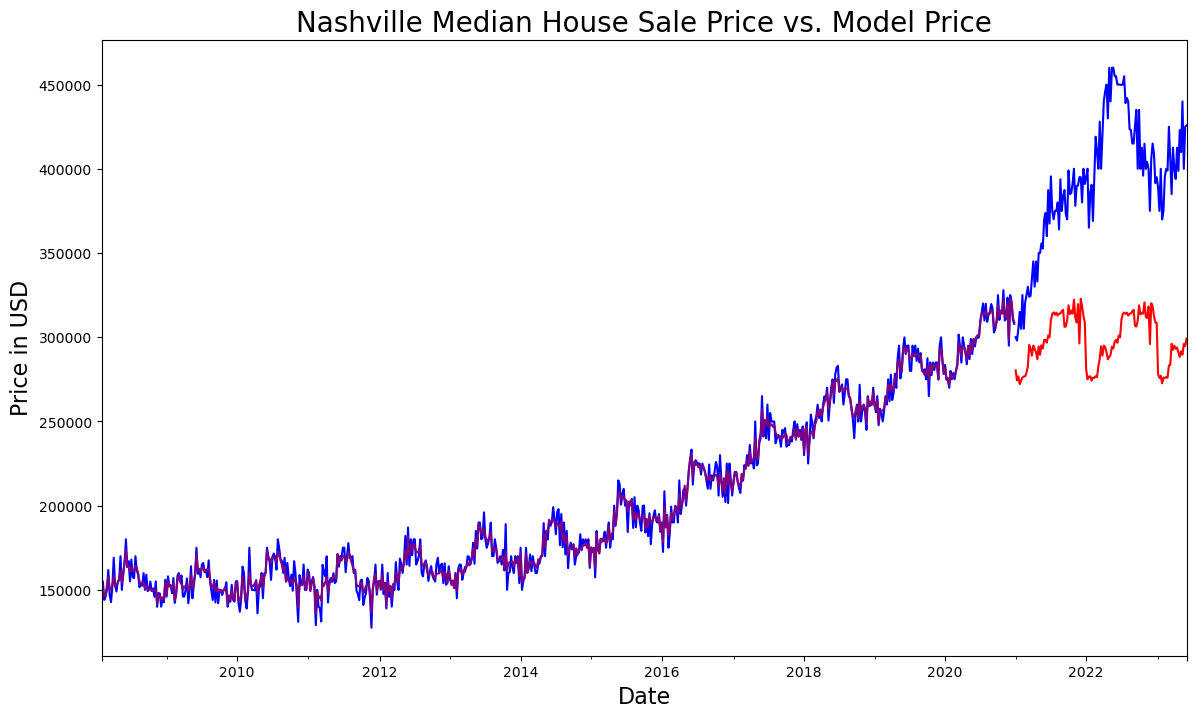

In [30]:
fig, ax = plt.subplots(figsize = (14,8))

nash_train['Price'].plot(color = 'blue')
nash_train['Predicted'].plot(color = 'purple')

nash_test['Price'].plot(color = 'blue')
nash_test['Predicted'].plot(color = 'red')


ax.set_title('Nashville Median House Sale Price vs. Model Price', fontsize = 20)

ax.set_xlabel('Date', fontsize = 16);
ax.set_ylabel('Price in USD', fontsize = 16)

plt.show();

In [31]:
nash_train = nash.loc[nash.index < '2018-01-01']
nash_test = nash.loc[(nash.index >= '2018-01-01') & (nash.index < '2020-01-01')]

In [32]:
X_train_nash = nash_train[features]
y_train_nash = nash_train['Price']

X_test_nash = nash_test[features]
y_test_nash = nash_test['Price']

In [33]:
reg_nash = xgb.XGBRegressor(n_estimators=1000, learning_rate = .01)
reg_nash.fit(X_train_nash, y_train_nash,
        eval_set=[(X_train_nash, y_train_nash), (X_test_nash, y_test_nash)],
        early_stopping_rounds=100,
       verbose=True)

[0]	validation_0-rmse:176925.95075	validation_1-rmse:266830.19886
[1]	validation_0-rmse:175179.96281	validation_1-rmse:264749.04400
[2]	validation_0-rmse:173451.48992	validation_1-rmse:262586.27737
[3]	validation_0-rmse:171740.30403	validation_1-rmse:260445.00721
[4]	validation_0-rmse:170046.24630	validation_1-rmse:258425.21483
[5]	validation_0-rmse:168369.11301	validation_1-rmse:256325.30116
[6]	validation_0-rmse:166708.75402	validation_1-rmse:254246.24966
[7]	validation_0-rmse:165065.00886	validation_1-rmse:252187.85734
[8]	validation_0-rmse:163437.71617	validation_1-rmse:250149.93099
[9]	validation_0-rmse:161826.66455	validation_1-rmse:248023.04766
[10]	validation_0-rmse:160231.72202	validation_1-rmse:245917.10043
[11]	validation_0-rmse:158652.69405	validation_1-rmse:243938.26391
[12]	validation_0-rmse:157089.45268	validation_1-rmse:241872.55212
[13]	validation_0-rmse:155541.84087	validation_1-rmse:239932.32375
[14]	validation_0-rmse:154009.68081	validation_1-rmse:237906.06839
[15]	

/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[44]	validation_0-rmse:114492.60909	validation_1-rmse:186912.61217
[45]	validation_0-rmse:113369.08714	validation_1-rmse:185498.10073
[46]	validation_0-rmse:112258.00539	validation_1-rmse:184008.58998
[47]	validation_0-rmse:111156.89273	validation_1-rmse:182621.76699
[48]	validation_0-rmse:110067.94428	validation_1-rmse:181160.65350
[49]	validation_0-rmse:108988.79657	validation_1-rmse:179800.97255
[50]	validation_0-rmse:107920.52064	validation_1-rmse:178454.86560
[51]	validation_0-rmse:106863.94070	validation_1-rmse:177034.90555
[52]	validation_0-rmse:105816.99265	validation_1-rmse:175715.14447
[53]	validation_0-rmse:104781.48260	validation_1-rmse:174322.25508
[54]	validation_0-rmse:103755.44490	validation_1-rmse:173028.33808
[55]	validation_0-rmse:102740.58806	validation_1-rmse:171661.98873
[56]	validation_0-rmse:101735.05532	validation_1-rmse:170393.44822
[57]	validation_0-rmse:100740.45165	validation_1-rmse:169053.13881
[58]	validation_0-rmse:99755.02537	validation_1-rmse:167809.45

[168]	validation_0-rmse:34502.48942	validation_1-rmse:81131.80413
[169]	validation_0-rmse:34180.33271	validation_1-rmse:80714.95035
[170]	validation_0-rmse:33861.65685	validation_1-rmse:80264.52119
[171]	validation_0-rmse:33545.91547	validation_1-rmse:79817.43588
[172]	validation_0-rmse:33233.42152	validation_1-rmse:79375.81634
[173]	validation_0-rmse:32924.29012	validation_1-rmse:78974.99225
[174]	validation_0-rmse:32617.97173	validation_1-rmse:78540.34750
[175]	validation_0-rmse:32314.90950	validation_1-rmse:78111.28970
[176]	validation_0-rmse:32014.83021	validation_1-rmse:77685.17082
[177]	validation_0-rmse:31718.10574	validation_1-rmse:77299.77044
[178]	validation_0-rmse:31424.67333	validation_1-rmse:76882.90344
[179]	validation_0-rmse:31133.94670	validation_1-rmse:76470.15804
[180]	validation_0-rmse:30845.93911	validation_1-rmse:76060.18818
[181]	validation_0-rmse:30561.54209	validation_1-rmse:75689.62234
[182]	validation_0-rmse:30279.67762	validation_1-rmse:75322.76858
[183]	vali

[293]	validation_0-rmse:11970.46266	validation_1-rmse:48863.50264
[294]	validation_0-rmse:11885.40947	validation_1-rmse:48729.51406
[295]	validation_0-rmse:11801.77914	validation_1-rmse:48593.92807
[296]	validation_0-rmse:11719.82574	validation_1-rmse:48462.53690
[297]	validation_0-rmse:11638.89394	validation_1-rmse:48332.41659
[298]	validation_0-rmse:11558.50268	validation_1-rmse:48203.02459
[299]	validation_0-rmse:11478.75421	validation_1-rmse:48075.41094
[300]	validation_0-rmse:11400.74068	validation_1-rmse:47960.62821
[301]	validation_0-rmse:11322.38933	validation_1-rmse:47832.61550
[302]	validation_0-rmse:11245.99410	validation_1-rmse:47720.03740
[303]	validation_0-rmse:11169.41683	validation_1-rmse:47597.09937
[304]	validation_0-rmse:11093.85236	validation_1-rmse:47474.20719
[305]	validation_0-rmse:11019.25669	validation_1-rmse:47351.01922
[306]	validation_0-rmse:10946.11614	validation_1-rmse:47231.64198
[307]	validation_0-rmse:10873.34705	validation_1-rmse:47113.04831
[308]	vali

[419]	validation_0-rmse:6468.38887	validation_1-rmse:39420.00936
[420]	validation_0-rmse:6450.45829	validation_1-rmse:39380.11024
[421]	validation_0-rmse:6433.68564	validation_1-rmse:39348.84035
[422]	validation_0-rmse:6415.66766	validation_1-rmse:39317.83929
[423]	validation_0-rmse:6398.18776	validation_1-rmse:39286.65136
[424]	validation_0-rmse:6381.84764	validation_1-rmse:39248.04891
[425]	validation_0-rmse:6365.94463	validation_1-rmse:39217.88937
[426]	validation_0-rmse:6348.85479	validation_1-rmse:39187.98771
[427]	validation_0-rmse:6333.25402	validation_1-rmse:39151.28128
[428]	validation_0-rmse:6318.46694	validation_1-rmse:39120.56188
[429]	validation_0-rmse:6302.51484	validation_1-rmse:39091.46986
[430]	validation_0-rmse:6287.59366	validation_1-rmse:39062.20265
[431]	validation_0-rmse:6272.55644	validation_1-rmse:39027.12993
[432]	validation_0-rmse:6256.88131	validation_1-rmse:38998.76488
[433]	validation_0-rmse:6243.06259	validation_1-rmse:38969.36355
[434]	validation_0-rmse:6

[546]	validation_0-rmse:5352.11899	validation_1-rmse:36856.91979
[547]	validation_0-rmse:5347.79790	validation_1-rmse:36846.19690
[548]	validation_0-rmse:5343.85706	validation_1-rmse:36836.48024
[549]	validation_0-rmse:5339.63283	validation_1-rmse:36825.93997
[550]	validation_0-rmse:5335.51311	validation_1-rmse:36816.39040
[551]	validation_0-rmse:5332.66490	validation_1-rmse:36805.75665
[552]	validation_0-rmse:5328.56367	validation_1-rmse:36795.66573
[553]	validation_0-rmse:5324.41824	validation_1-rmse:36785.22918
[554]	validation_0-rmse:5319.69425	validation_1-rmse:36774.96507
[555]	validation_0-rmse:5315.84359	validation_1-rmse:36764.71865
[556]	validation_0-rmse:5311.21020	validation_1-rmse:36754.62591
[557]	validation_0-rmse:5306.76982	validation_1-rmse:36744.35837
[558]	validation_0-rmse:5303.11103	validation_1-rmse:36734.39344
[559]	validation_0-rmse:5299.22249	validation_1-rmse:36724.92198
[560]	validation_0-rmse:5294.89811	validation_1-rmse:36715.14255
[561]	validation_0-rmse:5

[673]	validation_0-rmse:4873.42303	validation_1-rmse:36002.15853
[674]	validation_0-rmse:4866.97514	validation_1-rmse:35998.90480
[675]	validation_0-rmse:4864.68778	validation_1-rmse:35994.91934
[676]	validation_0-rmse:4861.34885	validation_1-rmse:35991.52202
[677]	validation_0-rmse:4854.99210	validation_1-rmse:35988.67142
[678]	validation_0-rmse:4848.71856	validation_1-rmse:35985.85273
[679]	validation_0-rmse:4846.14587	validation_1-rmse:35982.07474
[680]	validation_0-rmse:4842.88087	validation_1-rmse:35978.78712
[681]	validation_0-rmse:4836.69596	validation_1-rmse:35976.04484
[682]	validation_0-rmse:4830.59213	validation_1-rmse:35973.33040
[683]	validation_0-rmse:4829.24775	validation_1-rmse:35969.64598
[684]	validation_0-rmse:4823.22613	validation_1-rmse:35966.98673
[685]	validation_0-rmse:4820.02485	validation_1-rmse:35963.80794
[686]	validation_0-rmse:4814.08733	validation_1-rmse:35961.19843
[687]	validation_0-rmse:4811.81031	validation_1-rmse:35957.59517
[688]	validation_0-rmse:4

[800]	validation_0-rmse:4468.64083	validation_1-rmse:35763.11389
[801]	validation_0-rmse:4464.04286	validation_1-rmse:35760.11437
[802]	validation_0-rmse:4459.07315	validation_1-rmse:35759.65307
[803]	validation_0-rmse:4457.29206	validation_1-rmse:35758.09585
[804]	validation_0-rmse:4452.46911	validation_1-rmse:35757.53625
[805]	validation_0-rmse:4450.71423	validation_1-rmse:35755.99588
[806]	validation_0-rmse:4445.86533	validation_1-rmse:35755.09640
[807]	validation_0-rmse:4442.24445	validation_1-rmse:35755.27801
[808]	validation_0-rmse:4439.49300	validation_1-rmse:35755.21265
[809]	validation_0-rmse:4437.40275	validation_1-rmse:35753.30646
[810]	validation_0-rmse:4433.55254	validation_1-rmse:35753.61466
[811]	validation_0-rmse:4431.48458	validation_1-rmse:35751.56765
[812]	validation_0-rmse:4428.76951	validation_1-rmse:35751.76043
[813]	validation_0-rmse:4427.03943	validation_1-rmse:35750.28031
[814]	validation_0-rmse:4424.99580	validation_1-rmse:35748.26302
[815]	validation_0-rmse:4

[927]	validation_0-rmse:4143.87546	validation_1-rmse:35668.00067
[928]	validation_0-rmse:4141.97015	validation_1-rmse:35666.61454
[929]	validation_0-rmse:4138.54669	validation_1-rmse:35667.27362
[930]	validation_0-rmse:4136.58267	validation_1-rmse:35665.27378
[931]	validation_0-rmse:4134.73349	validation_1-rmse:35664.29706
[932]	validation_0-rmse:4132.78783	validation_1-rmse:35664.74855
[933]	validation_0-rmse:4130.96010	validation_1-rmse:35663.77922
[934]	validation_0-rmse:4127.19138	validation_1-rmse:35663.02526
[935]	validation_0-rmse:4126.77016	validation_1-rmse:35662.05989
[936]	validation_0-rmse:4122.99806	validation_1-rmse:35661.65458
[937]	validation_0-rmse:4122.58160	validation_1-rmse:35660.70537
[938]	validation_0-rmse:4119.73134	validation_1-rmse:35660.62398
[939]	validation_0-rmse:4117.54155	validation_1-rmse:35660.03726
[940]	validation_0-rmse:4115.28109	validation_1-rmse:35659.53753
[941]	validation_0-rmse:4112.08702	validation_1-rmse:35659.72503
[942]	validation_0-rmse:4

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [34]:
nash_train['Predicted'] = reg_nash.predict(X_train_nash)
nash_test['Predicted'] = reg_nash.predict(X_test_nash)

/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_8961/3632818493.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nash_train['Predicted'] = reg_nash.predict(X_train_nash)
/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_8961/3632818493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nash_test['Predicted'] = reg_nash.predict(X_test_nash)


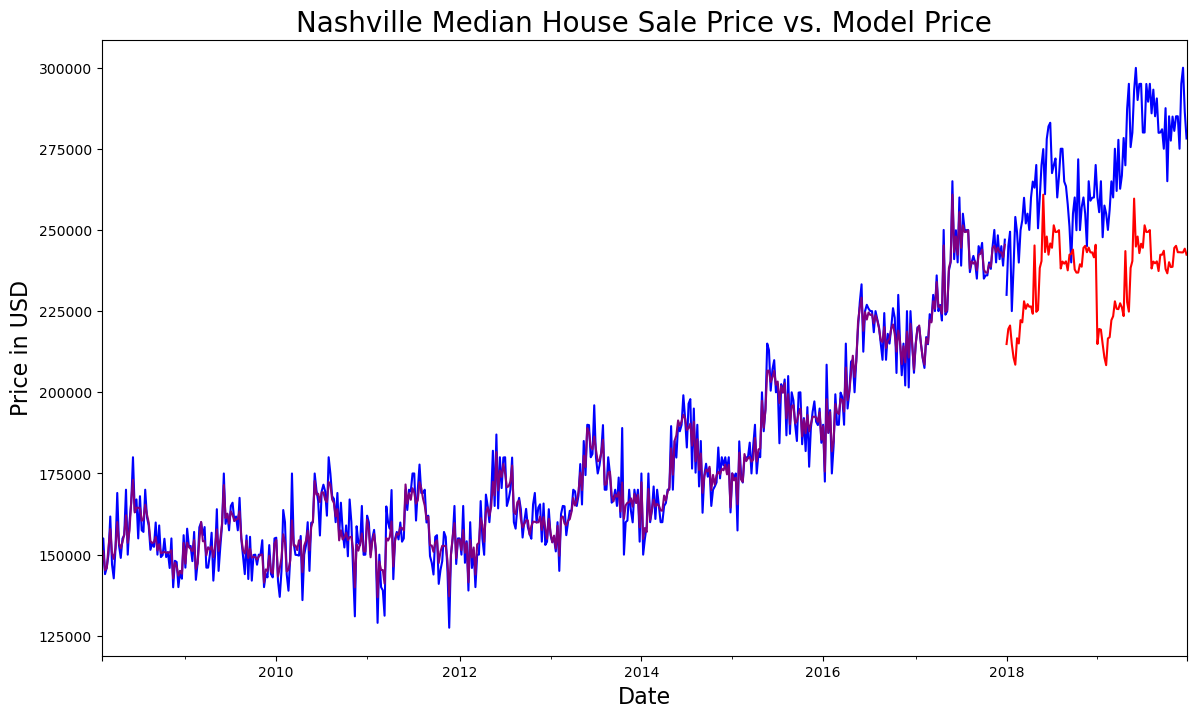

In [35]:
fig, ax = plt.subplots(figsize = (14,8))

nash_train['Price'].plot(color = 'blue')
nash_train['Predicted'].plot(color = 'purple')

nash_test['Price'].plot(color = 'blue')
nash_test['Predicted'].plot(color = 'red')


ax.set_title('Nashville Median House Sale Price vs. Model Price', fontsize = 20)

ax.set_xlabel('Date', fontsize = 16);
ax.set_ylabel('Price in USD', fontsize = 16)

plt.show();

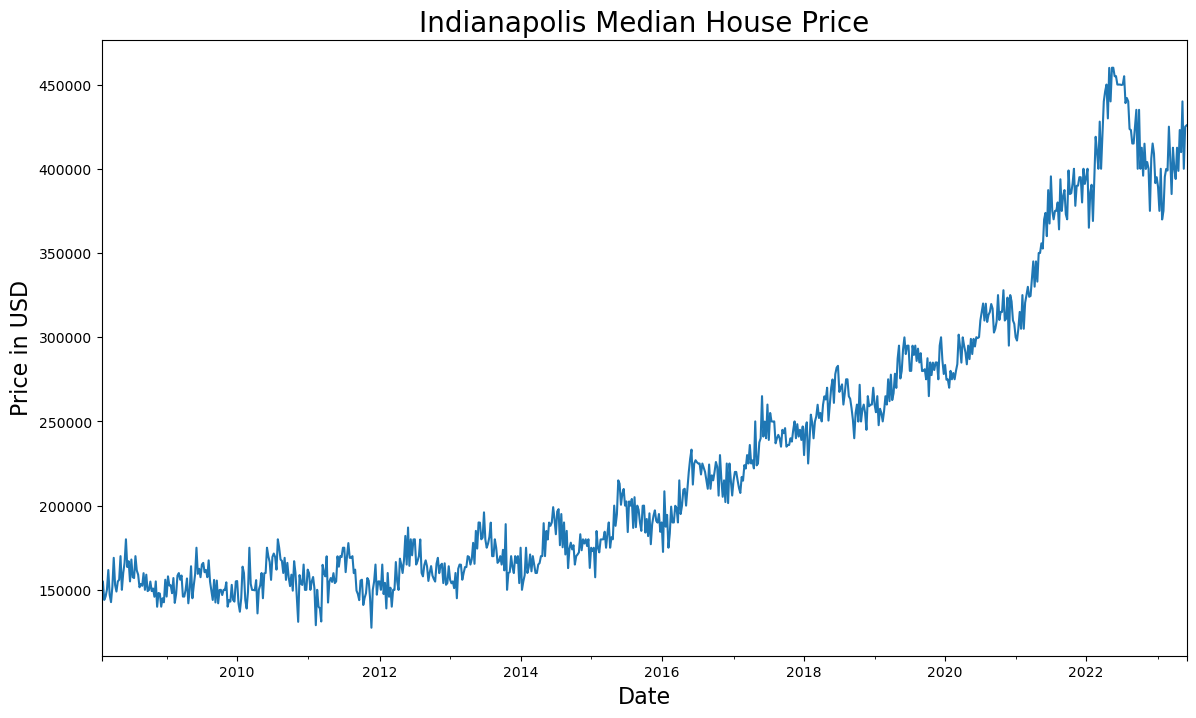

In [61]:
fig, ax = plt.subplots(figsize = (14,8))

indy['Price'].plot(ax = ax)

ax.set_title('Indianapolis Median House Price', fontsize = 20)

ax.set_xlabel('Date', fontsize = 16);
ax.set_ylabel('Price in USD', fontsize = 16)

plt.show();

In [40]:
indy = weekly_melt[weekly_melt['RegionName'] == 'Indianapolis, IN']

In [41]:
indy = date_features(nash)

In [42]:
indy_train = indy.loc[indy.index < '2021-01-01']
indy_test = indy.loc[(indy.index >= '2021-01-01')]

In [43]:
X_train_indy = indy_train[features]
y_train_indy = indy_train['Price']

X_test_indy = indy_test[features]
y_test_indy = indy_test['Price']

In [44]:
reg_indy = xgb.XGBRegressor(n_estimators=1000, learning_rate = .01)
reg_indy.fit(X_train_indy, y_train_indy,
        eval_set=[(X_train_indy, y_train_indy), (X_test_indy, y_test_indy)],
        early_stopping_rounds=100,
       verbose=True)

[0]	validation_0-rmse:204622.22156	validation_1-rmse:391763.79510
[1]	validation_0-rmse:202602.15335	validation_1-rmse:388937.17844
[2]	validation_0-rmse:200602.24757	validation_1-rmse:386138.72048
[3]	validation_0-rmse:198622.31454	validation_1-rmse:383368.19861
[4]	validation_0-rmse:196662.14855	validation_1-rmse:380625.33544
[5]	validation_0-rmse:194721.55600	validation_1-rmse:377909.84316
[6]	validation_0-rmse:192800.33992	validation_1-rmse:375221.41481
[7]	validation_0-rmse:190898.31613	validation_1-rmse:372559.82875
[8]	validation_0-rmse:189015.29406	validation_1-rmse:369924.80359
[9]	validation_0-rmse:187151.08337	validation_1-rmse:367316.08919
[10]	validation_0-rmse:185305.50231	validation_1-rmse:364733.40333
[11]	validation_0-rmse:183478.35563	validation_1-rmse:362176.52883
[12]	validation_0-rmse:181669.44358	validation_1-rmse:359645.15026
[13]	validation_0-rmse:179878.61482	validation_1-rmse:357139.05025
[14]	validation_0-rmse:178105.65649	validation_1-rmse:354658.00912
[15]	

[123]	validation_0-rmse:61123.95803	validation_1-rmse:189448.58889
[124]	validation_0-rmse:60534.76977	validation_1-rmse:188655.62414
[125]	validation_0-rmse:59952.28375	validation_1-rmse:187839.87732
[126]	validation_0-rmse:59375.47789	validation_1-rmse:186955.85420
[127]	validation_0-rmse:58803.68230	validation_1-rmse:186102.92818
[128]	validation_0-rmse:58237.90507	validation_1-rmse:185236.32260
[129]	validation_0-rmse:57677.54768	validation_1-rmse:184452.19166
[130]	validation_0-rmse:57123.51326	validation_1-rmse:183602.18230
[131]	validation_0-rmse:56574.38418	validation_1-rmse:182798.97467
[132]	validation_0-rmse:56030.80482	validation_1-rmse:182037.79349
[133]	validation_0-rmse:55492.75307	validation_1-rmse:181212.11201
[134]	validation_0-rmse:54960.59837	validation_1-rmse:180394.69983
[135]	validation_0-rmse:54432.86008	validation_1-rmse:179622.06662
[136]	validation_0-rmse:53910.43705	validation_1-rmse:178840.46469
[137]	validation_0-rmse:53393.50654	validation_1-rmse:178115.9

/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[151]	validation_0-rmse:46676.88567	validation_1-rmse:168159.73205
[152]	validation_0-rmse:46232.14834	validation_1-rmse:167536.80271
[153]	validation_0-rmse:45792.68146	validation_1-rmse:166883.50042
[154]	validation_0-rmse:45356.67353	validation_1-rmse:166242.06256
[155]	validation_0-rmse:44925.60914	validation_1-rmse:165601.55286
[156]	validation_0-rmse:44498.68867	validation_1-rmse:164958.42928
[157]	validation_0-rmse:44076.05227	validation_1-rmse:164365.46610
[158]	validation_0-rmse:43657.86364	validation_1-rmse:163743.46138
[159]	validation_0-rmse:43244.07348	validation_1-rmse:163127.60446
[160]	validation_0-rmse:42833.51996	validation_1-rmse:162508.99741
[161]	validation_0-rmse:42427.81708	validation_1-rmse:161910.28057
[162]	validation_0-rmse:42025.77346	validation_1-rmse:161345.82079
[163]	validation_0-rmse:41628.21876	validation_1-rmse:160753.62875
[164]	validation_0-rmse:41235.01651	validation_1-rmse:160167.30239
[165]	validation_0-rmse:40844.90416	validation_1-rmse:159574.6

[274]	validation_0-rmse:15444.76152	validation_1-rmse:121447.23057
[275]	validation_0-rmse:15321.69372	validation_1-rmse:121248.25345
[276]	validation_0-rmse:15199.58441	validation_1-rmse:121061.05219
[277]	validation_0-rmse:15079.31920	validation_1-rmse:120865.86718
[278]	validation_0-rmse:14960.20258	validation_1-rmse:120672.60330
[279]	validation_0-rmse:14841.91749	validation_1-rmse:120481.24174
[280]	validation_0-rmse:14725.66967	validation_1-rmse:120291.76861
[281]	validation_0-rmse:14610.49011	validation_1-rmse:120113.39364
[282]	validation_0-rmse:14496.77548	validation_1-rmse:119927.52789
[283]	validation_0-rmse:14384.18989	validation_1-rmse:119743.49129
[284]	validation_0-rmse:14272.74107	validation_1-rmse:119573.23896
[285]	validation_0-rmse:14162.57325	validation_1-rmse:119392.69174
[286]	validation_0-rmse:14053.88780	validation_1-rmse:119213.92323
[287]	validation_0-rmse:13945.35671	validation_1-rmse:119036.90553
[288]	validation_0-rmse:13839.08986	validation_1-rmse:118861.6

[398]	validation_0-rmse:7291.57365	validation_1-rmse:107381.00056
[399]	validation_0-rmse:7263.48825	validation_1-rmse:107318.32433
[400]	validation_0-rmse:7236.74253	validation_1-rmse:107261.61391
[401]	validation_0-rmse:7210.33932	validation_1-rmse:107204.22078
[402]	validation_0-rmse:7183.57790	validation_1-rmse:107146.76015
[403]	validation_0-rmse:7157.20903	validation_1-rmse:107091.06439
[404]	validation_0-rmse:7131.58824	validation_1-rmse:107035.83416
[405]	validation_0-rmse:7105.99209	validation_1-rmse:106980.53861
[406]	validation_0-rmse:7080.60094	validation_1-rmse:106921.76643
[407]	validation_0-rmse:7054.17564	validation_1-rmse:106864.13129
[408]	validation_0-rmse:7029.46131	validation_1-rmse:106809.71867
[409]	validation_0-rmse:7005.10830	validation_1-rmse:106753.17327
[410]	validation_0-rmse:6980.66372	validation_1-rmse:106698.45118
[411]	validation_0-rmse:6956.42121	validation_1-rmse:106644.26501
[412]	validation_0-rmse:6931.62142	validation_1-rmse:106589.31797
[413]	vali

[523]	validation_0-rmse:5485.86739	validation_1-rmse:103180.37318
[524]	validation_0-rmse:5479.65276	validation_1-rmse:103163.54541
[525]	validation_0-rmse:5472.98679	validation_1-rmse:103154.18027
[526]	validation_0-rmse:5467.01771	validation_1-rmse:103139.01168
[527]	validation_0-rmse:5461.07801	validation_1-rmse:103118.47231
[528]	validation_0-rmse:5455.20331	validation_1-rmse:103103.70533
[529]	validation_0-rmse:5449.27883	validation_1-rmse:103087.57664
[530]	validation_0-rmse:5443.15300	validation_1-rmse:103078.11626
[531]	validation_0-rmse:5437.36028	validation_1-rmse:103058.16683
[532]	validation_0-rmse:5431.72577	validation_1-rmse:103043.80079
[533]	validation_0-rmse:5426.09258	validation_1-rmse:103028.28893
[534]	validation_0-rmse:5420.68565	validation_1-rmse:103014.33273
[535]	validation_0-rmse:5414.90523	validation_1-rmse:102997.07561
[536]	validation_0-rmse:5409.50285	validation_1-rmse:102983.22349
[537]	validation_0-rmse:5403.81122	validation_1-rmse:102966.25661
[538]	vali

[648]	validation_0-rmse:4951.95157	validation_1-rmse:101989.27655
[649]	validation_0-rmse:4948.81899	validation_1-rmse:101983.88835
[650]	validation_0-rmse:4944.31403	validation_1-rmse:101977.77921
[651]	validation_0-rmse:4941.57862	validation_1-rmse:101972.43093
[652]	validation_0-rmse:4938.52151	validation_1-rmse:101967.38682
[653]	validation_0-rmse:4935.43278	validation_1-rmse:101961.62386
[654]	validation_0-rmse:4931.05041	validation_1-rmse:101956.18023
[655]	validation_0-rmse:4925.56670	validation_1-rmse:101950.72841
[656]	validation_0-rmse:4922.88452	validation_1-rmse:101945.07989
[657]	validation_0-rmse:4919.97536	validation_1-rmse:101941.20243
[658]	validation_0-rmse:4916.99576	validation_1-rmse:101936.11911
[659]	validation_0-rmse:4912.70107	validation_1-rmse:101930.62640
[660]	validation_0-rmse:4907.34380	validation_1-rmse:101925.42978
[661]	validation_0-rmse:4903.64698	validation_1-rmse:101923.65294
[662]	validation_0-rmse:4900.21751	validation_1-rmse:101918.25855
[663]	vali

[773]	validation_0-rmse:4572.09044	validation_1-rmse:101632.90297
[774]	validation_0-rmse:4569.18276	validation_1-rmse:101633.47694
[775]	validation_0-rmse:4564.96106	validation_1-rmse:101631.63329
[776]	validation_0-rmse:4563.24003	validation_1-rmse:101628.73592
[777]	validation_0-rmse:4560.66458	validation_1-rmse:101628.62105
[778]	validation_0-rmse:4558.90196	validation_1-rmse:101626.07092
[779]	validation_0-rmse:4554.73889	validation_1-rmse:101624.25637
[780]	validation_0-rmse:4551.91828	validation_1-rmse:101624.83210
[781]	validation_0-rmse:4549.90963	validation_1-rmse:101622.02355
[782]	validation_0-rmse:4547.86317	validation_1-rmse:101621.96545
[783]	validation_0-rmse:4546.53192	validation_1-rmse:101620.78678
[784]	validation_0-rmse:4544.80577	validation_1-rmse:101618.36773
[785]	validation_0-rmse:4540.65778	validation_1-rmse:101616.62084
[786]	validation_0-rmse:4538.95396	validation_1-rmse:101614.18317
[787]	validation_0-rmse:4537.75273	validation_1-rmse:101612.84496
[788]	vali

[899]	validation_0-rmse:4255.37675	validation_1-rmse:101570.68927
[900]	validation_0-rmse:4253.70877	validation_1-rmse:101572.65743
[901]	validation_0-rmse:4248.94643	validation_1-rmse:101570.54882
[902]	validation_0-rmse:4247.11946	validation_1-rmse:101571.14114
[903]	validation_0-rmse:4245.11694	validation_1-rmse:101570.07052
[904]	validation_0-rmse:4243.49899	validation_1-rmse:101570.69792
[905]	validation_0-rmse:4241.61771	validation_1-rmse:101571.68643
[906]	validation_0-rmse:4236.93507	validation_1-rmse:101569.61907
[907]	validation_0-rmse:4235.11486	validation_1-rmse:101569.81125
[908]	validation_0-rmse:4233.73101	validation_1-rmse:101571.23610
[909]	validation_0-rmse:4232.42802	validation_1-rmse:101570.68243
[910]	validation_0-rmse:4227.80884	validation_1-rmse:101568.63170
[911]	validation_0-rmse:4226.22581	validation_1-rmse:101569.42481
[912]	validation_0-rmse:4224.47523	validation_1-rmse:101569.84687
[913]	validation_0-rmse:4222.85739	validation_1-rmse:101571.09741
[914]	vali

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [45]:
indy_train['Predicted'] = reg_indy.predict(X_train_indy)
indy_test['Predicted'] = reg_indy.predict(X_test_indy)

/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_8961/3369512537.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indy_train['Predicted'] = reg_indy.predict(X_train_indy)
/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_8961/3369512537.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indy_test['Predicted'] = reg_indy.predict(X_test_indy)


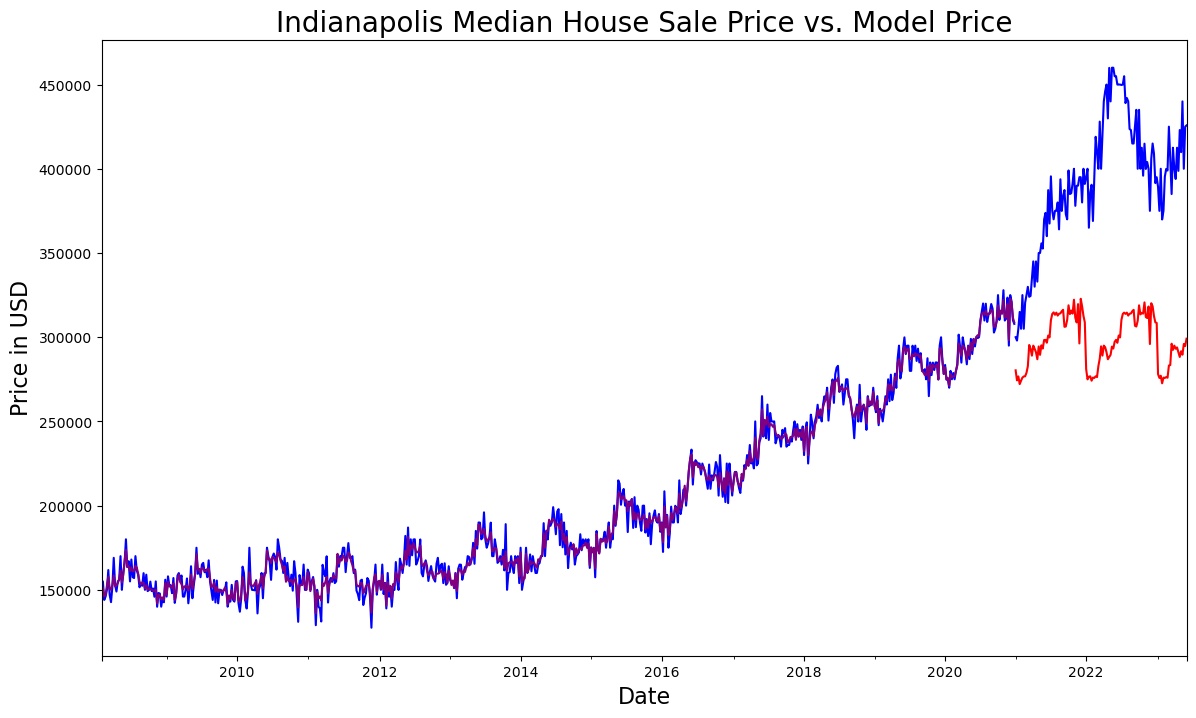

In [46]:
fig, ax = plt.subplots(figsize = (14,8))

indy_train['Price'].plot(color = 'blue')
indy_train['Predicted'].plot(color = 'purple')

indy_test['Price'].plot(color = 'blue')
indy_test['Predicted'].plot(color = 'red')


ax.set_title('Indianapolis Median House Sale Price vs. Model Price', fontsize = 20)

ax.set_xlabel('Date', fontsize = 16);
ax.set_ylabel('Price in USD', fontsize = 16)

plt.show();

In [47]:
indy_train = indy.loc[indy.index < '2018-01-01']
indy_test = indy.loc[(indy.index >= '2018-01-01') & (indy.index < '2020-01-01')]

In [48]:
X_train_indy = indy_train[features]
y_train_indy = indy_train['Price']

X_test_indy = indy_test[features]
y_test_indy = indy_test['Price']

In [49]:
reg_indy = xgb.XGBRegressor(n_estimators=1000, learning_rate = .01)
reg_indy.fit(X_train_indy, y_train_indy,
        eval_set=[(X_train_indy, y_train_indy), (X_test_indy, y_test_indy)],
        early_stopping_rounds=100,
       verbose=True)

[0]	validation_0-rmse:176925.95075	validation_1-rmse:266830.19886
[1]	validation_0-rmse:175179.96281	validation_1-rmse:264749.04400
[2]	validation_0-rmse:173451.48992	validation_1-rmse:262586.27737
[3]	validation_0-rmse:171740.30403	validation_1-rmse:260445.00721
[4]	validation_0-rmse:170046.24630	validation_1-rmse:258425.21483
[5]	validation_0-rmse:168369.11301	validation_1-rmse:256325.30116
[6]	validation_0-rmse:166708.75402	validation_1-rmse:254246.24966
[7]	validation_0-rmse:165065.00886	validation_1-rmse:252187.85734
[8]	validation_0-rmse:163437.71617	validation_1-rmse:250149.93099
[9]	validation_0-rmse:161826.66455	validation_1-rmse:248023.04766
[10]	validation_0-rmse:160231.72202	validation_1-rmse:245917.10043
[11]	validation_0-rmse:158652.69405	validation_1-rmse:243938.26391
[12]	validation_0-rmse:157089.45268	validation_1-rmse:241872.55212
[13]	validation_0-rmse:155541.84087	validation_1-rmse:239932.32375
[14]	validation_0-rmse:154009.68081	validation_1-rmse:237906.06839
[15]	

[124]	validation_0-rmse:52448.57571	validation_1-rmse:105487.20675
[125]	validation_0-rmse:51946.23626	validation_1-rmse:104845.34239
[126]	validation_0-rmse:51447.65004	validation_1-rmse:104152.39893
[127]	validation_0-rmse:50954.95759	validation_1-rmse:103521.09082
[128]	validation_0-rmse:50466.88590	validation_1-rmse:102841.24297
[129]	validation_0-rmse:49983.56753	validation_1-rmse:102168.15363
[130]	validation_0-rmse:49505.15767	validation_1-rmse:101501.75993
[131]	validation_0-rmse:49031.88694	validation_1-rmse:100896.49758
[132]	validation_0-rmse:48563.03075	validation_1-rmse:100242.70222
[133]	validation_0-rmse:48099.87099	validation_1-rmse:99595.41391
[134]	validation_0-rmse:47640.72166	validation_1-rmse:99007.70841
[135]	validation_0-rmse:47185.89581	validation_1-rmse:98372.65791
[136]	validation_0-rmse:46736.25575	validation_1-rmse:97761.40848
[137]	validation_0-rmse:46291.69839	validation_1-rmse:97190.74198
[138]	validation_0-rmse:45850.49131	validation_1-rmse:96573.62969
[

/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[174]	validation_0-rmse:32617.97173	validation_1-rmse:78540.34750
[175]	validation_0-rmse:32314.90950	validation_1-rmse:78111.28970
[176]	validation_0-rmse:32014.83021	validation_1-rmse:77685.17082
[177]	validation_0-rmse:31718.10574	validation_1-rmse:77299.77044
[178]	validation_0-rmse:31424.67333	validation_1-rmse:76882.90344
[179]	validation_0-rmse:31133.94670	validation_1-rmse:76470.15804
[180]	validation_0-rmse:30845.93911	validation_1-rmse:76060.18818
[181]	validation_0-rmse:30561.54209	validation_1-rmse:75689.62234
[182]	validation_0-rmse:30279.67762	validation_1-rmse:75322.76858
[183]	validation_0-rmse:30000.42777	validation_1-rmse:74924.32894
[184]	validation_0-rmse:29724.26310	validation_1-rmse:74530.84705
[185]	validation_0-rmse:29450.72900	validation_1-rmse:74139.98838
[186]	validation_0-rmse:29180.24826	validation_1-rmse:73787.26291
[187]	validation_0-rmse:28912.46865	validation_1-rmse:73404.97147
[188]	validation_0-rmse:28647.47983	validation_1-rmse:73026.45407
[189]	vali

[299]	validation_0-rmse:11478.75421	validation_1-rmse:48075.41094
[300]	validation_0-rmse:11400.74068	validation_1-rmse:47960.62821
[301]	validation_0-rmse:11322.38933	validation_1-rmse:47832.61550
[302]	validation_0-rmse:11245.99410	validation_1-rmse:47720.03740
[303]	validation_0-rmse:11169.41683	validation_1-rmse:47597.09937
[304]	validation_0-rmse:11093.85236	validation_1-rmse:47474.20719
[305]	validation_0-rmse:11019.25669	validation_1-rmse:47351.01922
[306]	validation_0-rmse:10946.11614	validation_1-rmse:47231.64198
[307]	validation_0-rmse:10873.34705	validation_1-rmse:47113.04831
[308]	validation_0-rmse:10801.92053	validation_1-rmse:46995.97246
[309]	validation_0-rmse:10731.36464	validation_1-rmse:46880.02842
[310]	validation_0-rmse:10661.55637	validation_1-rmse:46776.25264
[311]	validation_0-rmse:10592.31703	validation_1-rmse:46659.94469
[312]	validation_0-rmse:10524.24931	validation_1-rmse:46558.17475
[313]	validation_0-rmse:10458.08731	validation_1-rmse:46445.42071
[314]	vali

[424]	validation_0-rmse:6381.84764	validation_1-rmse:39248.04891
[425]	validation_0-rmse:6365.94463	validation_1-rmse:39217.88937
[426]	validation_0-rmse:6348.85479	validation_1-rmse:39187.98771
[427]	validation_0-rmse:6333.25402	validation_1-rmse:39151.28128
[428]	validation_0-rmse:6318.46694	validation_1-rmse:39120.56188
[429]	validation_0-rmse:6302.51484	validation_1-rmse:39091.46986
[430]	validation_0-rmse:6287.59366	validation_1-rmse:39062.20265
[431]	validation_0-rmse:6272.55644	validation_1-rmse:39027.12993
[432]	validation_0-rmse:6256.88131	validation_1-rmse:38998.76488
[433]	validation_0-rmse:6243.06259	validation_1-rmse:38969.36355
[434]	validation_0-rmse:6227.00641	validation_1-rmse:38934.75237
[435]	validation_0-rmse:6212.24768	validation_1-rmse:38907.15411
[436]	validation_0-rmse:6197.18544	validation_1-rmse:38879.78651
[437]	validation_0-rmse:6182.83817	validation_1-rmse:38851.40743
[438]	validation_0-rmse:6168.62108	validation_1-rmse:38818.26911
[439]	validation_0-rmse:6

[551]	validation_0-rmse:5332.66490	validation_1-rmse:36805.75665
[552]	validation_0-rmse:5328.56367	validation_1-rmse:36795.66573
[553]	validation_0-rmse:5324.41824	validation_1-rmse:36785.22918
[554]	validation_0-rmse:5319.69425	validation_1-rmse:36774.96507
[555]	validation_0-rmse:5315.84359	validation_1-rmse:36764.71865
[556]	validation_0-rmse:5311.21020	validation_1-rmse:36754.62591
[557]	validation_0-rmse:5306.76982	validation_1-rmse:36744.35837
[558]	validation_0-rmse:5303.11103	validation_1-rmse:36734.39344
[559]	validation_0-rmse:5299.22249	validation_1-rmse:36724.92198
[560]	validation_0-rmse:5294.89811	validation_1-rmse:36715.14255
[561]	validation_0-rmse:5289.93531	validation_1-rmse:36705.33464
[562]	validation_0-rmse:5285.86614	validation_1-rmse:36694.78571
[563]	validation_0-rmse:5281.69702	validation_1-rmse:36685.28005
[564]	validation_0-rmse:5276.82241	validation_1-rmse:36674.92277
[565]	validation_0-rmse:5272.73908	validation_1-rmse:36665.40484
[566]	validation_0-rmse:5

[678]	validation_0-rmse:4848.71856	validation_1-rmse:35985.85273
[679]	validation_0-rmse:4846.14587	validation_1-rmse:35982.07474
[680]	validation_0-rmse:4842.88087	validation_1-rmse:35978.78712
[681]	validation_0-rmse:4836.69596	validation_1-rmse:35976.04484
[682]	validation_0-rmse:4830.59213	validation_1-rmse:35973.33040
[683]	validation_0-rmse:4829.24775	validation_1-rmse:35969.64598
[684]	validation_0-rmse:4823.22613	validation_1-rmse:35966.98673
[685]	validation_0-rmse:4820.02485	validation_1-rmse:35963.80794
[686]	validation_0-rmse:4814.08733	validation_1-rmse:35961.19843
[687]	validation_0-rmse:4811.81031	validation_1-rmse:35957.59517
[688]	validation_0-rmse:4805.95155	validation_1-rmse:35955.03168
[689]	validation_0-rmse:4802.75986	validation_1-rmse:35951.94633
[690]	validation_0-rmse:4797.02707	validation_1-rmse:35949.80980
[691]	validation_0-rmse:4794.35189	validation_1-rmse:35946.29512
[692]	validation_0-rmse:4788.69593	validation_1-rmse:35944.50853
[693]	validation_0-rmse:4

[805]	validation_0-rmse:4450.71423	validation_1-rmse:35755.99588
[806]	validation_0-rmse:4445.86533	validation_1-rmse:35755.09640
[807]	validation_0-rmse:4442.24445	validation_1-rmse:35755.27801
[808]	validation_0-rmse:4439.49300	validation_1-rmse:35755.21265
[809]	validation_0-rmse:4437.40275	validation_1-rmse:35753.30646
[810]	validation_0-rmse:4433.55254	validation_1-rmse:35753.61466
[811]	validation_0-rmse:4431.48458	validation_1-rmse:35751.56765
[812]	validation_0-rmse:4428.76951	validation_1-rmse:35751.76043
[813]	validation_0-rmse:4427.03943	validation_1-rmse:35750.28031
[814]	validation_0-rmse:4424.99580	validation_1-rmse:35748.26302
[815]	validation_0-rmse:4421.37191	validation_1-rmse:35748.49508
[816]	validation_0-rmse:4416.64799	validation_1-rmse:35748.12757
[817]	validation_0-rmse:4415.23320	validation_1-rmse:35745.47526
[818]	validation_0-rmse:4410.48558	validation_1-rmse:35745.03454
[819]	validation_0-rmse:4407.80388	validation_1-rmse:35745.10075
[820]	validation_0-rmse:4

[932]	validation_0-rmse:4132.78783	validation_1-rmse:35664.74855
[933]	validation_0-rmse:4130.96010	validation_1-rmse:35663.77922
[934]	validation_0-rmse:4127.19138	validation_1-rmse:35663.02526
[935]	validation_0-rmse:4126.77016	validation_1-rmse:35662.05989
[936]	validation_0-rmse:4122.99806	validation_1-rmse:35661.65458
[937]	validation_0-rmse:4122.58160	validation_1-rmse:35660.70537
[938]	validation_0-rmse:4119.73134	validation_1-rmse:35660.62398
[939]	validation_0-rmse:4117.54155	validation_1-rmse:35660.03726
[940]	validation_0-rmse:4115.28109	validation_1-rmse:35659.53753
[941]	validation_0-rmse:4112.08702	validation_1-rmse:35659.72503
[942]	validation_0-rmse:4110.18543	validation_1-rmse:35660.13450
[943]	validation_0-rmse:4109.03563	validation_1-rmse:35660.84934
[944]	validation_0-rmse:4107.00727	validation_1-rmse:35658.65791
[945]	validation_0-rmse:4103.85299	validation_1-rmse:35658.85455
[946]	validation_0-rmse:4102.62892	validation_1-rmse:35657.77599
[947]	validation_0-rmse:4

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [50]:
indy_train['Predicted'] = reg_indy.predict(X_train_indy)
indy_test['Predicted'] = reg_indy.predict(X_test_indy)

/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_8961/3369512537.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indy_train['Predicted'] = reg_indy.predict(X_train_indy)
/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_8961/3369512537.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indy_test['Predicted'] = reg_indy.predict(X_test_indy)


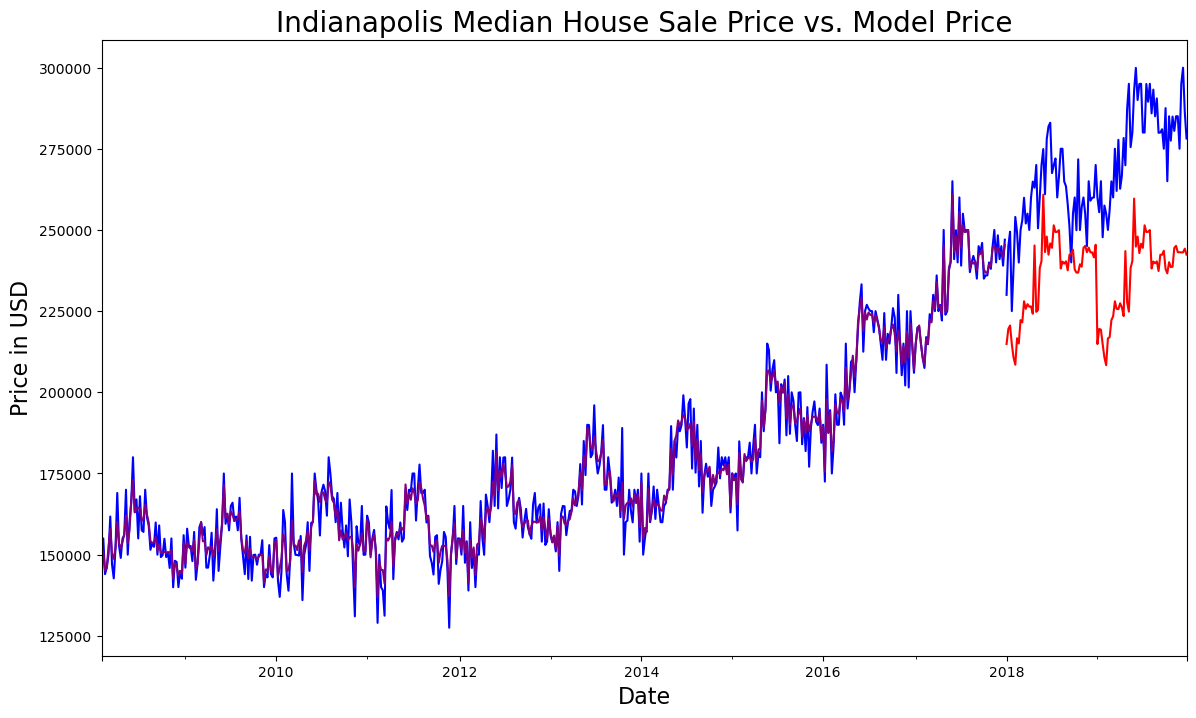

In [51]:
fig, ax = plt.subplots(figsize = (14,8))

indy_train['Price'].plot(color = 'blue')
indy_train['Predicted'].plot(color = 'purple')

indy_test['Price'].plot(color = 'blue')
indy_test['Predicted'].plot(color = 'red')


ax.set_title('Indianapolis Median House Sale Price vs. Model Price', fontsize = 20)

ax.set_xlabel('Date', fontsize = 16);
ax.set_ylabel('Price in USD', fontsize = 16)

plt.show();

In [57]:
X_train_nash = nash_train[features]
y_train_nash = nash_train['Price']

X_test_nash = nash_test[features]
y_test_nash = nash_test['Price']